# Multivariate Forecasting with NBEATS

This notebook outlines the application of NBEATS, a recently-proposed transformer-based model for time series forecasting, to a Electricity Consumption Dataset. The dataset contains the hourly electricity consumption of 321 customers from 2012 to 2014.





## Package Imports and Global Variables



In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install pytorch-forecasting

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import torch
import pytorch_lightning as pl
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_forecasting.metrics import NormalDistributionLoss
from pytorch_forecasting import TimeSeriesDataSet, Baseline, NBeats, GroupNormalizer, MultiNormalizer, EncoderNormalizer

In [5]:
DATA_PATH = "../datasets/electricity/electricity.csv"

EPOCHS = 1
VAL_PERC = .1
TEST_PERC = .005
BATCH_SIZE = 32

LAG_TIME = 30
LEAD_TIME = 30

## Data Loading

### Load Electricity Data File

In [6]:
df = pd.read_csv(DATA_PATH, index_col=0)
df = df.iloc[:, :-1]
df.index = pd.to_datetime(df.index)
df = df.reset_index().rename({'index':'date'}, axis=1)
df

,date,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319
0,2016-07-01 02:00:00,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,179.0,148.0,112.0,171.0,229.0,1001.0,49.0,162.0,594.0,88.0,34.0,885.0,122.0,102.0,425.0,185.0,360.0,83.0,449.0,37.0,408.0,346.0,521.0,177.0,4047.0,151.0,218.0,811.0,112.0,...,1062.0,2787.0,511.0,159.0,675.0,116.0,76.0,110.0,451.0,292.0,4770.0,123.0,1623.0,234.0,139.0,296.0,2412.0,317.0,16.0,164.0,241.0,575.0,1824.0,89.0,820.0,66.0,847.0,81.0,2002.0,937.0,199.0,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0
1,2016-07-01 03:00:00,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,235.0,192.0,143.0,213.0,301.0,1223.0,64.0,216.0,758.0,126.0,39.0,1074.0,150.0,127.0,585.0,219.0,451.0,108.0,606.0,60.0,548.0,470.0,632.0,224.0,4684.0,190.0,260.0,950.0,138.0,...,1048.0,2647.0,517.0,164.0,667.0,128.0,85.0,101.0,606.0,374.0,4189.0,149.0,2065.0,318.0,125.0,334.0,3166.0,385.0,32.0,123.0,318.0,750.0,2418.0,104.0,1268.0,87.0,988.0,91.0,2685.0,866.0,265.0,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0
2,2016-07-01 04:00:00,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,221.0,171.0,132.0,185.0,261.0,1172.0,61.0,197.0,736.0,115.0,38.0,936.0,149.0,117.0,551.0,193.0,433.0,102.0,616.0,53.0,472.0,452.0,551.0,213.0,4297.0,166.0,259.0,861.0,129.0,...,1014.0,2535.0,489.0,161.0,649.0,148.0,82.0,84.0,613.0,369.0,4041.0,112.0,1987.0,305.0,123.0,238.0,3194.0,384.0,32.0,123.0,294.0,725.0,2380.0,120.0,1254.0,88.0,942.0,77.0,2661.0,839.0,278.0,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0
3,2016-07-01 05:00:00,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,170.0,149.0,116.0,151.0,209.0,813.0,40.0,173.0,661.0,93.0,21.0,833.0,114.0,86.0,434.0,145.0,351.0,78.0,449.0,54.0,375.0,410.0,491.0,170.0,3252.0,114.0,180.0,685.0,128.0,...,987.0,2350.0,511.0,166.0,661.0,155.0,76.0,87.0,621.0,369.0,4031.0,115.0,1970.0,305.0,207.0,211.0,3075.0,384.0,24.0,164.0,279.0,725.0,2375.0,119.0,1246.0,87.0,867.0,102.0,2684.0,838.0,271.0,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0
4,2016-07-01 06:00:00,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,142.0,170.0,99.0,136.0,148.0,688.0,29.0,144.0,619.0,86.0,20.0,815.0,80.0,73.0,304.0,118.0,289.0,75.0,347.0,44.0,288.0,377.0,479.0,148.0,2639.0,86.0,141.0,623.0,115.0,...,953.0,2357.0,524.0,160.0,649.0,121.0,82.0,87.0,622.0,370.0,4056.0,111.0,1971.0,312.0,158.0,212.0,3059.0,388.0,32.0,123.0,259.0,725.0,2367.0,110.0,1212.0,86.0,819.0,103.0,2692.0,828.0,267.0,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,2019-07-01 21:00:00,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,332.0,163.0,239.0,371.0,403.0,1941.0,64.0,357.0,936.0,174.0,88.0,1782.0,172.0,199.0,593.0,373.0,717.0,136.0,954.0,40.0,930.0,625.0,325.0,378.0,8298.0,306.0,412.0,1016.0,194.0,...,2231.0,4839.0,705.0,371.0,793.0,607.0,268.0,368.0,878.0,1676.0,10626.0,535.0,3485.0,1199.0,449.0,492.0,7592.0,1546.0,0.0,82.0,799.0,1470.0,4838.0,327.0,1764.0,232.0,2353.0,94.0,5502.0,2065.0,178.0,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0
26300,2019-07-01 22:00:00,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,307.0,160.0,213.0,349.0,361.0,1721.0,61.0,325.0,878.0,171.0,104.0,1614.0,164.0,200.0,554.0,366.0,678.0,125.0,842.0,43.0,741.0,553.0,273.0,332.0,7070.0,275.0,394.0,846.0,185.0,...,945.0,2654.0,665.0,185.0,339.0,623.0,93.0,388.0,877.0,1668.0,7884.0,225.0,2930.0,619.0,134.0,218.0,5413.0,1

### Data Preprocessing
The data is split sequentially into train, validation and test based on `VAL_SIZE` and `TEST_SIZE` global variables. 

In [7]:
n_samples = len(df)
n_val = int(n_samples * VAL_PERC)
n_test = int(n_samples * TEST_PERC)
n_train = n_samples - (n_val + n_test)

# Split data into train and test
train_df = df.iloc[:n_train, :]
val_df = df.iloc[n_train:n_train+n_val]
test_df = df.iloc[n_train+n_val:]

# Rename index to time_idx
train_df = train_df.reset_index().rename({'index':'time_idx'}, axis=1)
val_df = val_df.reset_index().rename({'index':'time_idx'}, axis=1)
test_df = test_df.reset_index().rename({'index':'time_idx'}, axis=1)

train_df['group_ids'] = 0
val_df['group_ids'] = 0
test_df['group_ids'] = 0

In [8]:
# Flatten dataframes into single series 
train_df = train_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
val_df = val_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')
test_df = test_df.melt(id_vars=['time_idx', 'date'], value_vars=df.columns, var_name='group_ids')

In [9]:
# Define datasets
train_data = TimeSeriesDataSet(
    train_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(train_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

val_data = TimeSeriesDataSet(
    val_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(val_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

test_data = TimeSeriesDataSet(
    test_df,  
    time_idx="time_idx",
    target="value",
    categorical_encoders={"group_ids": NaNLabelEncoder().fit(test_df.group_ids)},
    group_ids=['group_ids'],
    max_encoder_length=LAG_TIME,
    max_prediction_length=LEAD_TIME,
    time_varying_unknown_reals=["value"],
)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:621: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,


In [ ]:
# Define dataloader
train_dataloader = train_data.to_dataloader(train=True, batch_size=BATCH_SIZE, num_workers=4)
val_dataloader = val_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)
test_dataloader = test_data.to_dataloader(train=False, batch_size=BATCH_SIZE, num_workers=4)

## Model

### NBEATS Overview

<p align="center">
<img width="430" alt="Screen Shot 2022-01-25 at 6 19 35 PM" src="https://user-images.githubusercontent.com/34798787/155443902-04fd5960-dd90-4198-be6f-047ac35fa26b.png">
</p>

NBEATS is a popular deep learning based approach to univariate time series forecasting. The architecture consists of deep stacks of fully connected layers connected with forward and backward residual links. The forwad links aggregate partial forecast to yield final forecast. Alternatively, backward links subtract out input signal corresponding to already predicted partial forecast from input prior to being passed to the next stack. Some additional features of NBEATS include: 
- **Interpretability**: Allows for hierarchical decomposition of a forecasts into trend and seasonal components which enhances interpretability. 
- **Ensembling**: Ensembles models fit with different loss functions and time horizons. The final prediction is mean of models in ensemble. 
- **Extensible to Multivariate**: Although  univariate, NBEATS is often used as a global model that is trained and performs inference on a set of related time series.





In [ ]:
# Set random seed 
pl.seed_everything(42)

# Define early stopping criteria
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")

# Init pytorch lightning trainer
trainer = pl.Trainer(
    max_epochs=EPOCHS,
    gpus=1,
    weights_summary="top",
    #gradient_clip_val=0.01,
    callbacks=[early_stop_callback],
    limit_train_batches=.2,
    limit_val_batches=.2,
)

# Init model with structure specified in dataset
net = NBeats.from_dataset(
    train_data,
    learning_rate=1e-4,
    weight_decay=1e-2
)

# Train and Validate Model
trainer.fit(
    net,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader
)

In [11]:
# Load best model from checkpoint
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = NBeats.load_from_checkpoint(best_model_path)

## Test

## Visualize Predictions

With the trained model from the previous step, we can apply it to the test set to get an unbias estimate of the models performance. Additionally, we can visualize the results to build some intuition about the forecasts being generated.

In [12]:
# Get predictions from test dataset
preds = best_model.predict(test_dataloader)

# Aggregate inputs, ground truth and classes into tensor alligned with predictions
input_list, true_list, class_list = [], [], []
for x, y in test_dataloader: 
    input_list.append(x["encoder_target"])
    true_list.append(y[0])
    class_list.append(x["groups"])


inputs = torch.cat(input_list)
trues = torch.cat(true_list)
classes = torch.cat(class_list)

print(inputs.shape, preds.shape, trues.shape, classes.shape)

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-7 - consider not centering the data or using data with higher variance for numerical stability
  UserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/data/encoders.py:376: UserWarning: scale is below 1e-

torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 30]) torch.Size([23040, 1])


In [13]:
# Select indices of samples to visualize
n_samples = 10
ss_indices = np.random.choice(range(preds.shape[0]), n_samples, replace=False)
ss_pred = preds[ss_indices]
ss_true = trues[ss_indices]
ss_input = inputs[ss_indices]
ss_class = classes[ss_indices]

print(ss_input.shape, ss_pred.shape, ss_true.shape, ss_class.shape)

torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 30]) torch.Size([10, 1])


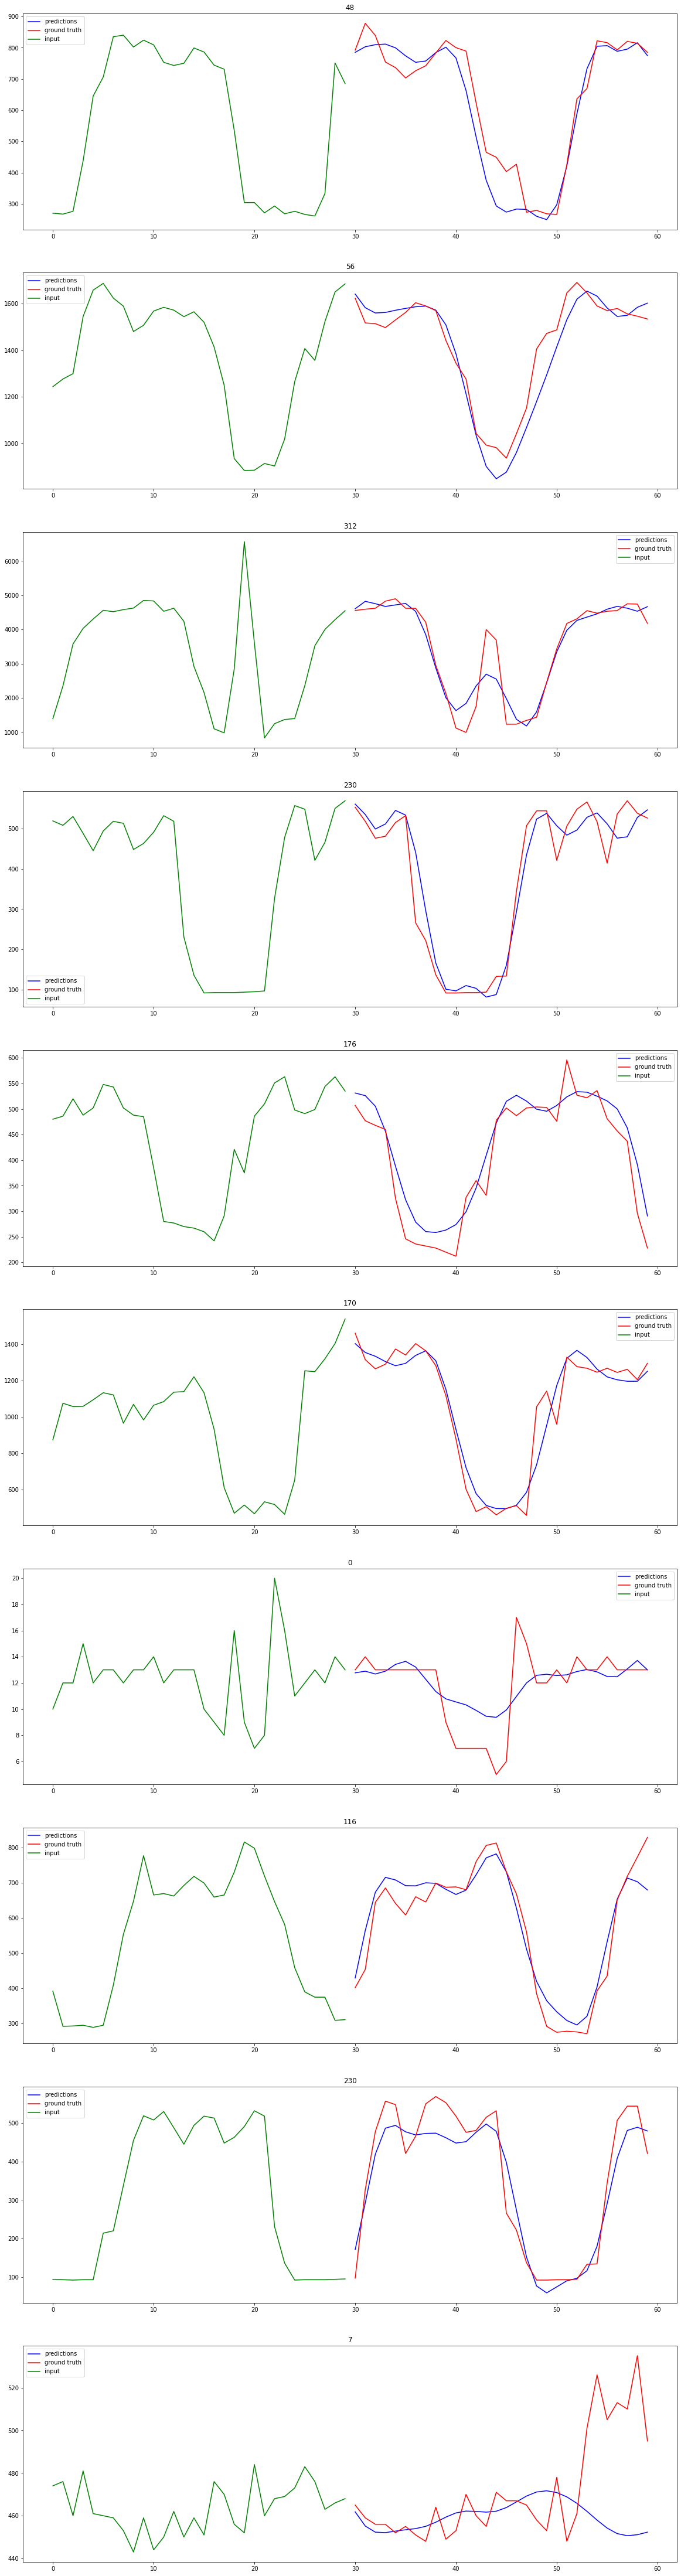

In [14]:
# Loop through samples and plot input, ground truth and prediction
f, axarr = plt.subplots(n_samples, 1, figsize=(20, 80))
for i in range(n_samples):
    series_preds = ss_pred[i, :].squeeze()
    series_trues = ss_true[i, :].squeeze()
    series_inputs = ss_input[i, :].squeeze()

    feat_name = str(ss_class[i].item())
    
    input_len = series_inputs.shape[0]
    pred_gt_len = series_preds.shape[0]
    input_x = np.array([i for i in range(input_len)])
    x = np.array([i for i in range(input_len, input_len+pred_gt_len)])
    axarr[i].plot(x, series_preds, c="blue", label="predictions")
    axarr[i].plot(x, series_trues, c="red", label="ground truth")
    axarr[i].plot(input_x, series_inputs, c="green", label="input")
    axarr[i].legend()
    axarr[i].set_title(feat_name)

### Quantitative Resutls
To assess the performance of NBEATS on the dataset, we calculate its performance on the test set using a set of metrics that are commonly used in time series forecasting. The metrics include Mean Absolute Error (MAE)and Mean Squared Error (MSE).

In [17]:
# Calculate losses
mse = mean_squared_error(trues.cpu().numpy(), preds.cpu().numpy())
mae = mean_absolute_error(trues.cpu().numpy(), preds.cpu().numpy())

print(f"MSE: {mse} MAE: {mae}")

MSE: 824497.4375 MAE: 181.01446533203125
